In [ ]:
# 📦 Load required libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(readr)
library(ggsignif)
library(ggpubr)
library(DESeq2)
library(biomaRt)
library(rlang)


In [3]:
# 📥 Load DESeq2 object
dds <- readRDS("/home/layanomics/CrispAstro-Seq/04_differential_expression/results/dds.rds")


In [ ]:
# 🔧 Custom top error bar function (same as NES)
geom_top_errorbar <- function(data,
                              x = "x_numeric",
                              y = "mean_expression",
                              yend = "y_top",
                              whisker_width = 0.4,
                              linewidth = 0.6,
                              color = "black") {
    x_sym <- sym(x)
    y_sym <- sym(y)
    yend_sym <- sym(yend)

    list(
        geom_segment(
            data = data,
            mapping = aes(x = !!x_sym, xend = !!x_sym, y = !!y_sym, yend = !!yend_sym),
            linewidth = linewidth, color = color, inherit.aes = FALSE
        ),
        geom_segment(
            data = data,
            mapping = aes(
                x = !!x_sym - whisker_width / 2,
                xend = !!x_sym + whisker_width / 2,
                y = !!yend_sym, yend = !!yend_sym
            ),
            linewidth = linewidth, color = color, inherit.aes = FALSE
        )
    )
}


In [5]:
# 🧬 Define gene ID for C3
c3_ensg_id <- "ENSG00000125730"
if (!(c3_ensg_id %in% rownames(dds))) {
    stop("C3 gene not found.")
}

# 📊 Extract normalized counts
c3_counts <- as.numeric(counts(dds, normalized = TRUE)[c3_ensg_id, ])
sample_data <- as.data.frame(colData(dds))

# 📈 Combine for plotting
plot_data <- data.frame(
    condition = sample_data$condition,
    expression = c3_counts
)

# 📏 Normalize to WT
wt_mean <- mean(plot_data$expression[plot_data$condition == "WT"])
plot_data$relative_expression <- plot_data$expression / wt_mean

# 📊 Summary stats
summary_data <- plot_data %>%
    group_by(condition) %>%
    summarise(
        mean_expression = mean(relative_expression),
        se_expression = sd(relative_expression) / sqrt(n())
    ) %>%
    mutate(
        x_numeric = as.numeric(factor(condition)),
        y_top = mean_expression + se_expression
    )

# 🧪 T-test and significance label
t_test_result <- t.test(relative_expression ~ condition, data = plot_data)
p_value <- t_test_result$p.value
significance_label <- ifelse(p_value < 0.001, "***",
    ifelse(p_value < 0.05, "*", "ns")
)


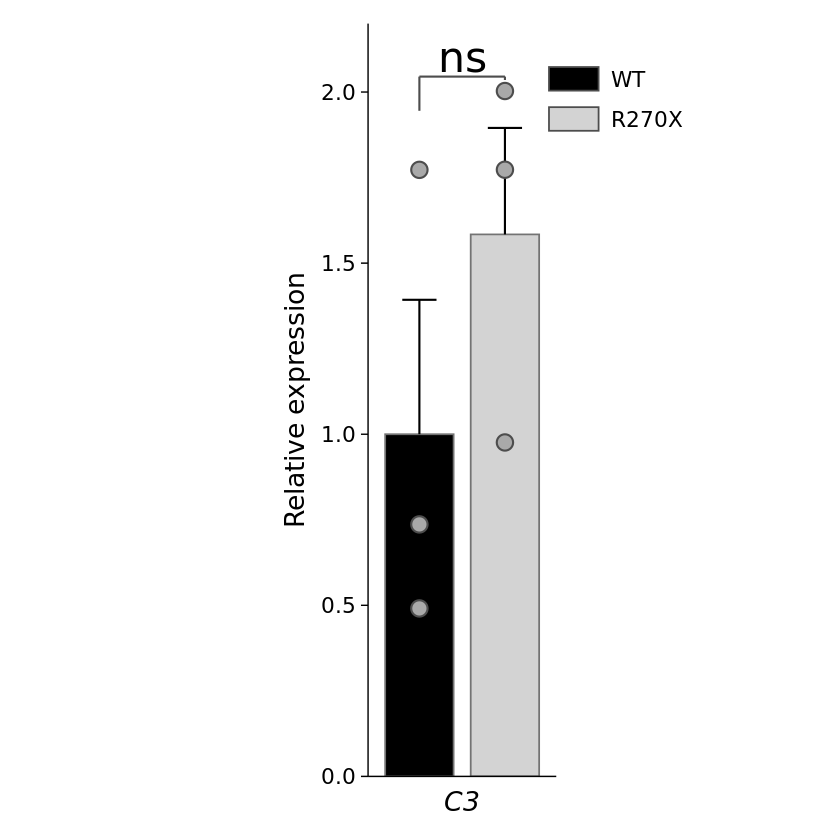

In [6]:
# 📍 Significance line position
y_sig <- max(summary_data$y_top) + 0.15

# 📊 Plot C3
p_c3 <- ggplot(plot_data, aes(x = condition, y = relative_expression)) +
    geom_bar(
        data = summary_data,
        aes(y = mean_expression, fill = condition),
        stat = "identity",
        width = 0.8,
        color = "grey45",
        linewidth = 0.5
    ) +
    geom_top_errorbar(summary_data) +
    geom_point(
        color = "grey30",
        fill = "darkgrey",
        shape = 21, size = 4.0, stroke = 0.9
    ) +
    scale_fill_manual(values = c("WT" = "black", "R270X" = "lightgray")) +
    annotate("text", x = 1.5, y = y_sig + 0.06, label = significance_label, size = 9) +
    annotate("segment",
        x = 1, xend = 2, y = y_sig, yend = y_sig,
        color = "grey30", linewidth = 0.6
    ) +
    annotate("segment",
        x = 1, xend = 1, y = y_sig, yend = y_sig - 0.1,
        color = "grey30", linewidth = 0.6
    ) +
    annotate("segment",
        x = 2, xend = 2, y = y_sig, yend = y_sig - 0.01,
        color = "grey30", linewidth = 0.6
    ) +
    labs(x = expression(italic("C3")), y = "Relative expression") +
    scale_y_continuous(limits = c(0, 2.2), breaks = seq(0, 2.2, 0.5), expand = c(0, 0)) +
    theme_minimal(base_size = 14) +
    theme(
        axis.line = element_line(color = "black", linewidth = 0.4),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_line(color = "black", linewidth = 0.4),
        axis.ticks.length.y = unit(0.15, "cm"),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 13, color = "black"),
        axis.title.x = element_text(face = "italic", size = 16, color = "black", margin = margin(t = 5)),
        axis.title.y = element_text(size = 16, margin = margin(r = 10), color = "black"),
        legend.position = "inside",
        legend.position.inside = c(1.3, 0.9),
        legend.title = element_blank(),
        legend.text = element_text(size = 13, color = "black"),
        legend.background = element_rect(fill = "white", color = NA),
        legend.key = element_rect(fill = "white", color = NA),
        legend.box = "vertical",
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.spacing.y = unit(0.3, "cm"),
        legend.margin = margin(t = 5, b = 5),
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"),
        aspect.ratio = 4 / 1
    ) +
    guides(fill = guide_legend(
        override.aes = list(shape = 22, size = 5, color = "grey30"),
        keywidth = unit(1.1, "cm"),
        keyheight = unit(0.4, "cm"),
        byrow = TRUE
    ))

# 🔍 Display
print(p_c3)
